In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# import fancyimpute

# os.chdir('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project')
df = pd.read_csv('hospitalDataTarget.csv')

In [3]:
df.head()

Unnamed: 0 Provider ID  COMP_HIP_KNEE  MORT_30_AMI  MORT_30_CABG  \
0           0      010001            3.0         14.5           4.5   
1           1      010005            3.0         15.5           NaN   
2           2      010006            3.6         14.9           3.2   
3           3      010007            2.8          NaN           NaN   
4           5      010011            2.6         14.1           3.7   

   MORT_30_COPD  MORT_30_HF  MORT_30_PN  MORT_30_STK  PSI_10_POST_KIDNEY  ...  \
0           8.9        12.5        16.2         13.7                0.65  ...   
1          10.9        15.3        20.8         15.7                1.10  ...   
2           8.8        13.2        17.2         17.2                1.28  ...   
3           8.3        13.3        21.6         15.9                1.30  ...   
4           8.9        13.1        16.1         12.4                1.74  ...   

   H_HSP_RATING_LINEAR_SCORE  H_QUIET_LINEAR_SCORE  H_RECMND_LINEAR_SCORE  \
0                         83                    86                     84   
1                         88                    85                     88   
2                         84                    82                     84   
3                         85                    86                     85   
4                         87                    81                     86   

                      Hospital Name                     Address        City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE      DOTHAN   
1     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH        BOAZ   
2    ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET    FLORENCE   
3          MIZELL MEMORIAL HOSPITAL               702 N MAIN ST         OPP   
4                 ST VINCENT'S EAST  50 MEDICAL PARK EAST DRIVE  BIRMINGHAM   

   State  ZIP Code  Number of Completed Surveys  Survey Response Rate Percent  
0     AL   36301.0                          506                            21  
1     AL   35957.0                         1135                            34  
2     AL   35631.0                          579                            22  
3     AL   36467.0                          185                            27  
4     AL   35235.0                         2193                            33  

[5 rows x 38 columns]

In [4]:
# what is the pattern of the blank scores needing to be filled?

df.isnull().sum(axis=0)

Unnamed: 0                         0
Provider ID                        0
COMP_HIP_KNEE                    870
MORT_30_AMI                     1149
MORT_30_CABG                    2516
MORT_30_COPD                     438
MORT_30_HF                       291
MORT_30_PN                       196
MORT_30_STK                      991
PSI_10_POST_KIDNEY               828
PSI_11_POST_RESP                 848
PSI_12_POSTOP_PULMEMB_DVT        625
PSI_13_POST_SEPSIS               841
PSI_14_POSTOP_DEHIS              805
PSI_15_ACC_LAC                   655
PSI_3_ULCER                      573
PSI_4_SURG_COMP                 1823
PSI_6_IAT_PTX                    564
PSI_8_POST_HIP                   564
PSI_90_SAFETY                    562
PSI_9_POST_HEM                   628
H_CLEAN_LINEAR_SCORE               0
H_COMP_1_LINEAR_SCORE              0
H_COMP_2_LINEAR_SCORE              0
H_COMP_3_LINEAR_SCORE              0
H_COMP_5_LINEAR_SCORE              0
H_COMP_6_LINEAR_SCORE              0
H

Since they have less than half of the records populated, we will consider removing MORT_30_CABG and PSI_4_SURG_COMP when we run our models.

In [5]:
# set metadata - we will not impute values for these, but will add back later

df_metadata = df[['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code']]

In [6]:
df_survey_predictors = df[['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']]

df_survey_predictors.head()
df_survey_predictors.isnull().sum(axis=0)

COMP_HIP_KNEE                    870
MORT_30_AMI                     1149
MORT_30_CABG                    2516
MORT_30_COPD                     438
MORT_30_HF                       291
MORT_30_PN                       196
MORT_30_STK                      991
PSI_10_POST_KIDNEY               828
PSI_11_POST_RESP                 848
PSI_12_POSTOP_PULMEMB_DVT        625
PSI_13_POST_SEPSIS               841
PSI_14_POSTOP_DEHIS              805
PSI_15_ACC_LAC                   655
PSI_3_ULCER                      573
PSI_4_SURG_COMP                 1823
PSI_6_IAT_PTX                    564
PSI_8_POST_HIP                   564
PSI_90_SAFETY                    562
PSI_9_POST_HEM                   628
H_CLEAN_LINEAR_SCORE               0
H_COMP_1_LINEAR_SCORE              0
H_COMP_2_LINEAR_SCORE              0
H_COMP_3_LINEAR_SCORE              0
H_COMP_5_LINEAR_SCORE              0
H_COMP_6_LINEAR_SCORE              0
H_COMP_7_LINEAR_SCORE              0
H_HSP_RATING_LINEAR_SCORE          0
H

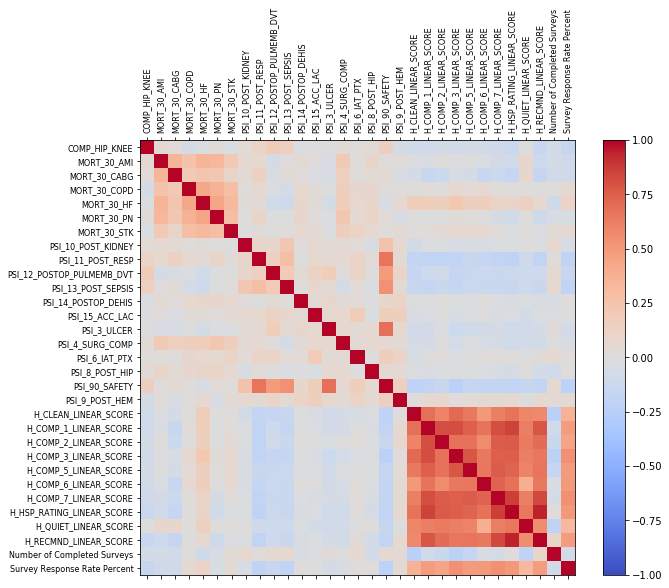

In [14]:

corr = df_survey_predictors.corr()
# fig = plt.figure()
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_survey_predictors.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_survey_predictors.columns, fontsize=8)
ax.set_yticklabels(df_survey_predictors.columns, fontsize=8)
plt.show()

Survey response rate % seems to be the most correlated with survey scores. However, there are 716 rows that don't have response rate provided, so we will have to work around that. Since the survey responses seem to be all or nothing (they are either all populated or all null), we can't use one survey response to predict another, despite the high correlation between them. In addition, all of the complication rates have missing values that will need to be examined separately and filled.

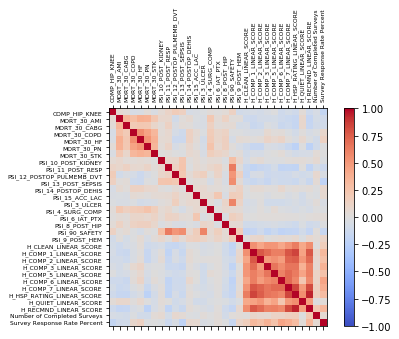

In [74]:
# out of curiosity - let's see how the correlation matrix is affected when you keep only 
# filled rows

df_predictors = df[['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']]
df_drop_na = df_predictors.dropna(how='any')
df_drop_na.count()

corr = df_drop_na.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_drop_na.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_drop_na.columns, fontsize=6)
ax.set_yticklabels(df_drop_na.columns, fontsize=6)
plt.show()

# doesn't particularly highlight other correlations, and actually removes the useful negative
# correlation between number of completed surveys and survey scores

We'll try two methods using fancyimpute. The first is IterativeImputer, which models each feature as a function of other features (mulitple regression). The second is KNN, which chooses the 3 nearest neighbors that have the feature filled and takes the average of those.

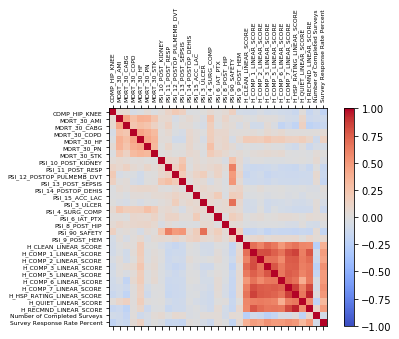

In [75]:
# Model each feature with missing values as a function of other features, and
# use that estimate for imputation.
#filled_iterative_np = fancyimpute.IterativeImputer().fit_transform(df_predictors)

df_filled_iterative = pd.DataFrame(filled_iterative_np)
df_filled_iterative.columns = ['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']
df_filled_iterative.head()

corr = df_filled_iterative.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_filled_iterative.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_filled_iterative.columns, fontsize=6)
ax.set_yticklabels(df_filled_iterative.columns, fontsize=6)
plt.show()

# looks like the correlations we saw before are generally retained

In [76]:
# look at means of each measure

df_filled_iterative.mean()

COMP_HIP_KNEE                     2.605102
MORT_30_AMI                      13.210216
MORT_30_CABG                      3.340519
MORT_30_COPD                      8.387088
MORT_30_HF                       11.750039
MORT_30_PN                       15.749078
MORT_30_STK                      14.243472
PSI_10_POST_KIDNEY                1.310920
PSI_11_POST_RESP                  8.110251
PSI_12_POSTOP_PULMEMB_DVT         3.802057
PSI_13_POST_SEPSIS                5.222166
PSI_14_POSTOP_DEHIS               0.857925
PSI_15_ACC_LAC                    1.290815
PSI_3_ULCER                       0.382598
PSI_4_SURG_COMP                 161.284288
PSI_6_IAT_PTX                     0.289004
PSI_8_POST_HIP                    0.110929
PSI_90_SAFETY                     0.996808
PSI_9_POST_HEM                    2.594627
H_CLEAN_LINEAR_SCORE             87.965146
H_COMP_1_LINEAR_SCORE            91.375177
H_COMP_2_LINEAR_SCORE            91.430434
H_COMP_3_LINEAR_SCORE            85.736753
H_COMP_5_LI

In [77]:
# Use 10 nearest rows which have a feature to fill in each row's missing features

filled_knn_np = fancyimpute.KNN(k=10).fit_transform(df_predictors)

Imputing row 1/3529 with 0 missing, elapsed time: 2.729
Imputing row 101/3529 with 1 missing, elapsed time: 2.739
Imputing row 201/3529 with 3 missing, elapsed time: 2.751
Imputing row 301/3529 with 0 missing, elapsed time: 2.756
Imputing row 401/3529 with 0 missing, elapsed time: 2.764
Imputing row 501/3529 with 2 missing, elapsed time: 2.779
Imputing row 601/3529 with 0 missing, elapsed time: 2.787
Imputing row 701/3529 with 0 missing, elapsed time: 2.791
Imputing row 801/3529 with 2 missing, elapsed time: 2.799
Imputing row 901/3529 with 2 missing, elapsed time: 2.813
Imputing row 1001/3529 with 1 missing, elapsed time: 2.819
Imputing row 1101/3529 with 2 missing, elapsed time: 2.830
Imputing row 1201/3529 with 13 missing, elapsed time: 2.846
Imputing row 1301/3529 with 8 missing, elapsed time: 2.860
Imputing row 1401/3529 with 10 missing, elapsed time: 2.874
Imputing row 1501/3529 with 2 missing, elapsed time: 2.885
Imputing row 1601/3529 with 16 missing, elapsed time: 2.890
Imputi

In [78]:
# convert knn np array back to dataframe and rename columns

df_filled_knn = pd.DataFrame(filled_knn_np)
df_filled_knn.columns = ['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
              'MORT_30_STK', 'PSI_10_POST_KIDNEY', 'PSI_11_POST_RESP', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
              'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER', 'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX',
              'PSI_8_POST_HIP', 'PSI_90_SAFETY', 'PSI_9_POST_HEM', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
              'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
              'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'Number of Completed Surveys', 'Survey Response Rate Percent']
df_filled_knn.head()
df_filled_knn.isnull().sum(axis=0)

COMP_HIP_KNEE                   0
MORT_30_AMI                     0
MORT_30_CABG                    0
MORT_30_COPD                    0
MORT_30_HF                      0
MORT_30_PN                      0
MORT_30_STK                     0
PSI_10_POST_KIDNEY              0
PSI_11_POST_RESP                0
PSI_12_POSTOP_PULMEMB_DVT       0
PSI_13_POST_SEPSIS              0
PSI_14_POSTOP_DEHIS             0
PSI_15_ACC_LAC                  0
PSI_3_ULCER                     0
PSI_4_SURG_COMP                 0
PSI_6_IAT_PTX                   0
PSI_8_POST_HIP                  0
PSI_90_SAFETY                   0
PSI_9_POST_HEM                  0
H_CLEAN_LINEAR_SCORE            0
H_COMP_1_LINEAR_SCORE           0
H_COMP_2_LINEAR_SCORE           0
H_COMP_3_LINEAR_SCORE           0
H_COMP_5_LINEAR_SCORE           0
H_COMP_6_LINEAR_SCORE           0
H_COMP_7_LINEAR_SCORE           0
H_HSP_RATING_LINEAR_SCORE       0
H_QUIET_LINEAR_SCORE            0
H_RECMND_LINEAR_SCORE           0
Number of Comp

In [79]:
# reattach provider IDs and location columns to datasets

final_filled_iterative = pd.concat([df_metadata, df_filled_iterative], axis=1)
final_filled_knn = pd.concat([df_metadata, df_filled_knn], axis=1)

In [80]:
# print iterativeImpute and knn filled datasets to csv

final_filled_iterative.to_csv('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project/filled_iterative.csv')
final_filled_knn.to_csv('C:/Users/mgow/Documents/UChicago/Courses/Data Mining/Group Project/filled_knn.csv')